In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
combined_data = [file for file in glob.glob1("data/RNASeq_bw", "*stranded*") if "unstranded" not in file]
combined_tab_files = [file for file in combined_data if file.endswith(".tab")]
combined_tab_files_name_sorted = sorted(combined_tab_files, key=lambda x: x[0])
combined_tab_files_names = [file[ :file.find("_")] for file in combined_tab_files]

tab_files = sorted([file for file in glob.glob1("data/RNASeq_bw", "*.tab") if ("plus" in file or "minus" in file) and ("gene_added" not in file)] + [file for file in glob.glob1("data/RNASeq_bw", "*.tab") if "unstranded" in file], key=lambda x: (x[0], x[x.find(".") + 1: x.find(".") + 2]))
tab_files_name_sorted = [file[: file.find("_")] for file in tab_files]

In [31]:
# Getting the sum of RNA signals from the TSS onward (individual samples).
GM12878_files = []
K562_files = []

GM12878_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
K562_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")

with pd.option_context("mode.chained_assignment", None):
    for file in tqdm(tab_files, desc="File"):
        file_name = file[ :file.find("_")]
        cell_line = file[ :file.find(".")]
        gene_list = None

        if cell_line == "K562":
            gene_list = K562_gene_list
        elif cell_line == "GM12878":
            gene_list = GM12878_gene_list

        df = pd.read_csv(f"data/RNASeq_bw/{file}", sep="\t", skiprows=3, header=None)

        # Summing from the TSS to the right of the sample.
        df_tss = df.iloc[:, 62:]
        df_tss.loc[:, "ENSID"] = gene_list.loc[:, "Ensembl_ID"]
        df_tss.loc[:, "Sum"] = df_tss.iloc[:, :-1].sum(axis=1)
        reorder = list(df_tss)[-2:-1] + list(df_tss)[:-2] + list(df_tss)[-1:]
        df_tss = df_tss.loc[:, reorder]

        if cell_line == "K562":
            K562_files.append(df_tss.loc[:, "Sum"])
        elif cell_line == "GM12878":
            GM12878_files.append(df_tss.loc[:, "Sum"])

        plt.plot(range(len(df_tss)), df_tss.loc[: ,"Sum"])
        plt.xlabel("Gene")
        plt.ylabel("Sum of Bins")
        plt.title(f"Genes vs Sum of the TSS and the Bins to the Right for {file_name}", fontsize=8)
        plt.savefig(f"plots/dist_tss_sum_individual/{file_name}.sum_tss_bins.png")
        plt.clf()

gm12878 = pd.DataFrame(GM12878_files).T
gm12878.to_csv("./data/gm12878_tss_sum_individual.csv", index=False)
k562 = pd.DataFrame(K562_files).T
k562.to_csv("./data/k562_tss_sum_individual.csv", index=False)

File: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
# Getting the sum of RNA signals from the TSS onward (combined samples).
GM12878_files = []
K562_files = []

GM12878_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
K562_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")

with pd.option_context("mode.chained_assignment", None):
    for file in tqdm(combined_tab_files, desc="File"):
        file_name = file[ :file.find("_")]
        cell_line = file[ :file.find(".")]
        gene_list = None

        if cell_line == "K562":
            gene_list = K562_gene_list
        elif cell_line == "GM12878":
            gene_list = GM12878_gene_list

        df = pd.read_csv(f"data/RNASeq_bw/{file}", sep="\t")
        df = df.iloc[:, :-1]

        # Summing from the TSS to the right of the sample.
        df_tss = df.iloc[:, 62:]
        df_tss.loc[:, "ENSID"] = gene_list.loc[:, "Ensembl_ID"]
        df_tss.loc[:, "Sum"] = df_tss.iloc[:, :-1].sum(axis=1)
        reorder = list(df_tss)[-2:-1] + list(df_tss)[:-2] + list(df_tss)[-1:]
        df_tss = df_tss.loc[:, reorder]

        if cell_line == "K562":
            K562_files.append(df_tss.loc[:, "Sum"])
        elif cell_line == "GM12878":
            GM12878_files.append(df_tss.loc[:, "Sum"])

        plt.plot(range(len(df_tss)), df_tss.loc[: ,"Sum"])
        plt.xlabel("Gene")
        plt.ylabel("Sum of Bins")
        plt.title("Genes vs Sum of the TSS and the Bins to the Right")
        plt.savefig(f"plots/dist_tss_sum/{file_name}.sum_tss_bins.png")
        plt.clf()

gm12878 = pd.DataFrame(GM12878_files).T
gm12878.to_csv("./data/gm12878_tss_sum.csv", index=False)
k562 = pd.DataFrame(K562_files).T
k562.to_csv("./data/k562_tss_sum.csv", index=False)

File: 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


<Figure size 640x480 with 0 Axes>

In [67]:
# Our RNA Seq vs Our CAGE-Seq (individual samples)
gm_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
k5_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")

gm12878 = pd.read_csv("data/gm12878_tss_sum_individual.csv")
gm12878[["Ensembl_ID", "TSS"]] = gm_gene_list[["Ensembl_ID", "tss"]]

k562 = pd.read_csv("data/k562_tss_sum_individual.csv")
k562[["Ensembl_ID", "TSS"]] = k5_gene_list[["Ensembl_ID", "tss"]]

rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")

gm_cage = gm12878.merge(rna_cage, left_on="Ensembl_ID", right_on="ENSID", how="inner", suffixes=["_gm12878", "_cage"])
gm_cage = gm_cage[["Sum", "Sum.1", "Sum.2", "Sum.3", "Sum.4", "Sum.5", "Sum.6", "Sum.7", "Sum.8", "Sum.9", "Sum.10", "Sum.11", "GM12878_CAGE_128*3_sum"]]
gm_cage.columns = range(len(gm_cage.columns))
gm_cage = gm_cage.dropna()

k5_cage = k562.merge(rna_cage, left_on="Ensembl_ID", right_on="ENSID", how="inner", suffixes=["_k562", "_cage"])
k5_cage = k5_cage[["Sum", "Sum.1", "Sum.2", "Sum.3", "Sum.4", "Sum.5", "Sum.6", "Sum.7", "Sum.8", "Sum.9", "Sum.10", "Sum.11", "K562_CAGE_128*3_sum"]]
k5_cage.columns = range(len(k5_cage.columns))
k5_cage = k5_cage.dropna()

gm_cage_correlation = pd.DataFrame()
for col in gm_cage.columns[0:12]:
    file_name = tab_files_name_sorted[int(col)]

    pearson_r_values = stats.pearsonr(np.log(gm_cage[12] + 1), np.log(gm_cage[col] + 1))
    gm_cage_correlation = pd.concat([gm_cage_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(gm_cage[12], gm_cage[col])
    plt.xlabel("CAGE Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title(f"CAGE vs RNA Seq Values for {file_name}", fontsize=8)
    # plt.show()
    plt.savefig(f"plots/rnaseq_vs_rnacage_individual/{file_name}.rna_seq_xpresso_log.png")
    plt.clf()

k5_cage_correlation = pd.DataFrame()
for col in k5_cage.columns[0:12]:
    file_name = tab_files_name_sorted[int(col) + 12]

    pearson_r_values = stats.pearsonr(np.log(k5_cage[12] + 1), np.log(k5_cage[col] + 1))
    k5_cage_correlation = pd.concat([k5_cage_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(k5_cage[12], k5_cage[col])
    plt.xlabel("CAGE Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title(f"CAGE vs RNA Seq Values for {file_name}", fontsize=8)
    plt.savefig(f"plots/rnaseq_vs_rnacage_individual/{file_name}.rna_seq_xpresso_log.png")
    plt.clf()

gm_cage_correlation["Sample"] = tab_files_name_sorted[0:12]
k5_cage_correlation["Sample"] = tab_files_name_sorted[12:]
gm_cage_correlation.to_csv("csvs/correlation/rnaseq_vs_rnacage_individual/gm_seq_vs_cage_individual.csv", index=False)
k5_cage_correlation.to_csv("csvs/correlation/rnaseq_vs_rnacage_individual/k5_seq_vs_cage_individual.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [24]:
gm12878

,Sum,Sum.1,Sum.2,Sum.3,Ensembl_ID,TSS
0,25.28964,51.07226,45.85330,49.62014,ENSG00000310526,29359
1,55965.94844,59831.07230,7822.10092,9871.88037,ENSG00000225630,629640
2,85317.91183,107808.94850,36544.13665,33648.15372,ENSG00000237973,631074
3,3977.23148,4840.24540,107.21060,47.71101,ENSG00000229344,632757
4,69380.23026,82356.24390,19755.29154,16564.33043,ENSG00000240409,633535
...,...,...,...,...,...,...
29072,0.00000,0.00000,0.00000,0.00000,ENSG00000288057,21456216
29073,0.00000,0.00000,0.00000,0.00000,ENSG00000290336,22308884
29074,0.00000,0.00000,0.00000,0.00000,ENSG00000187191,24813393
29075,0.00000,0.00000,0.00000,0.00000,ENSG00000205916,24833917


In [25]:
combined_tab_files_name_sorted

['GM12878.stranded.ENCFF985TNZ.ENCFF892WMR_values_TSS.tab',
 'GM12878.stranded.ENCFF037DUE.ENCFF078ATR_values_TSS.tab',
 'GM12878.stranded.ENCFF164VLA.ENCFF074SXQ_values_TSS.tab',
 'GM12878.stranded.ENCFF182LTN.ENCFF546NVF_values_TSS.tab',
 'K562.stranded.ENCFF040DXX.ENCFF777EAJ_values_TSS.tab',
 'K562.stranded.ENCFF006DQI.ENCFF964BAP_values_TSS.tab',
 'K562.stranded.ENCFF097ASF.ENCFF528VFJ_values_TSS.tab',
 'K562.stranded.ENCFF336COA.ENCFF829PNJ_values_TSS.tab']

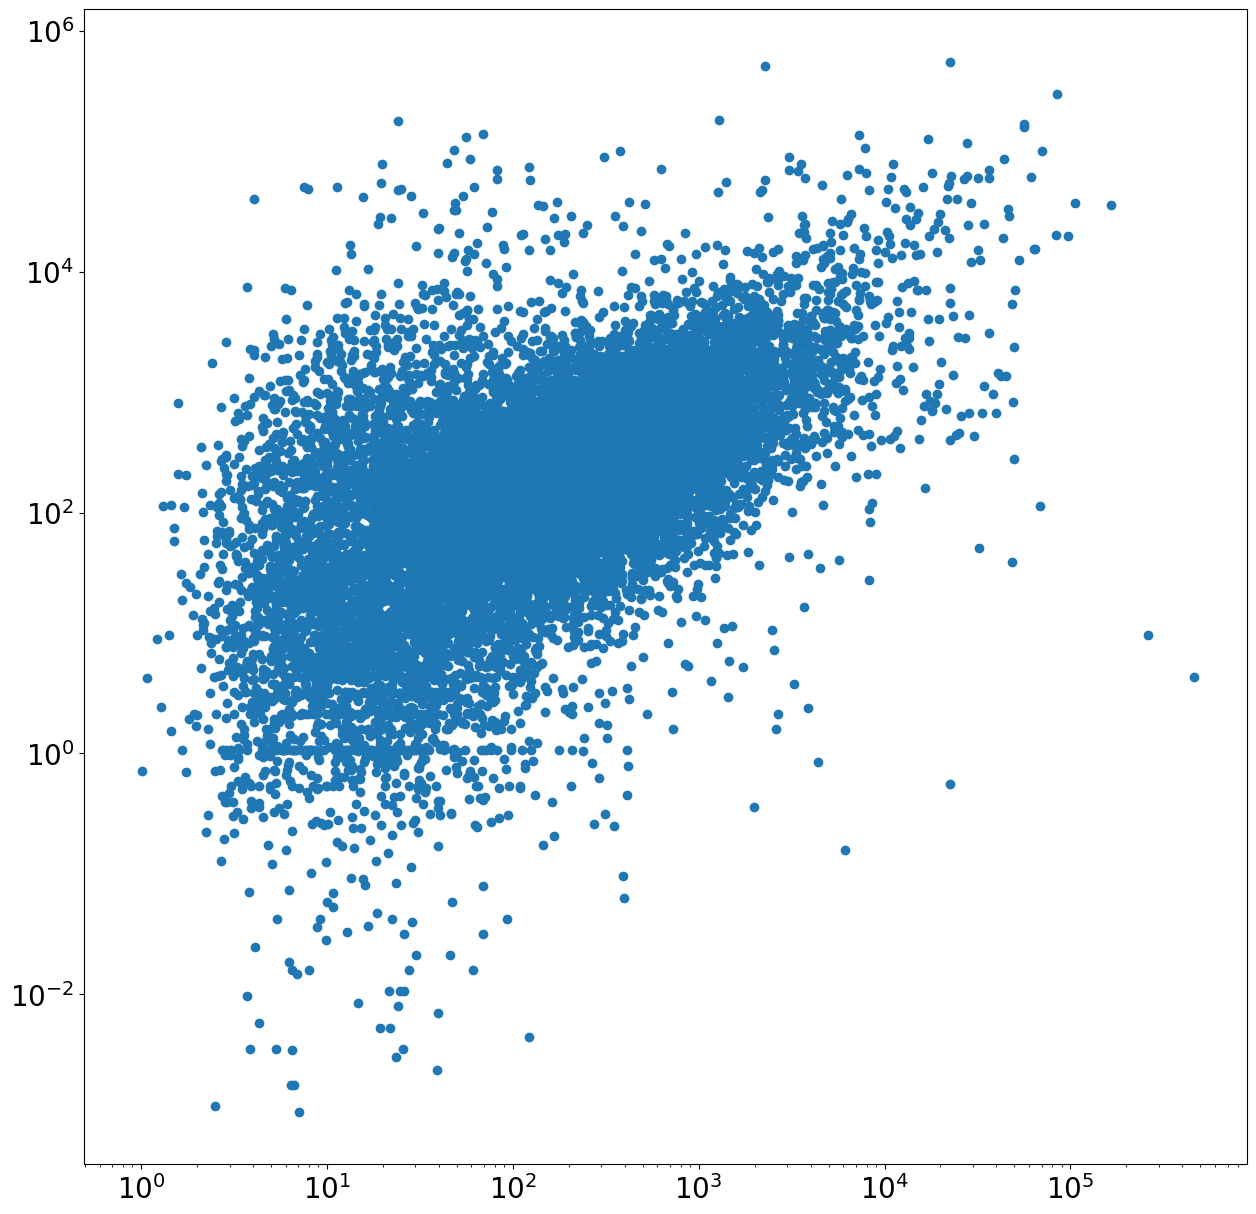

In [12]:
# Our RNA Seq vs Our CAGE-Seq (combined samples)
gm_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
k5_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")

gm12878 = pd.read_csv("data/gm12878_tss_sum.csv")
gm12878[["Ensembl_ID", "TSS"]] = gm_gene_list[["Ensembl_ID", "tss"]]

k562 = pd.read_csv("data/k562_tss_sum.csv")
k562[["Ensembl_ID", "TSS"]] = k5_gene_list[["Ensembl_ID", "tss"]]

rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")

gm_cage = gm12878.merge(rna_cage, left_on="Ensembl_ID", right_on="ENSID", how="inner", suffixes=["_gm12878", "_cage"])
gm_cage = gm_cage[["Sum", "Sum.1", "Sum.2", "Sum.3", "GM12878_CAGE_128*3_sum"]]
gm_cage.columns = range(len(gm_cage.columns))
gm_cage = gm_cage.dropna()

k5_cage = k562.merge(rna_cage, left_on="Ensembl_ID", right_on="ENSID", how="inner", suffixes=["_k562", "_cage"])
k5_cage = k5_cage[["Sum", "Sum.1", "Sum.2", "Sum.3", "K562_CAGE_128*3_sum"]]
k5_cage.columns = range(len(k5_cage.columns))
k5_cage = k5_cage.dropna()

gm_cage_correlation = pd.DataFrame()
for col in gm_cage.columns[2:3]:
    file_name = combined_tab_files_name_sorted[int(col)][ :combined_tab_files_name_sorted[int(col)].find("_")]

    pearson_r_values = stats.pearsonr(np.log(gm_cage[4] + 1), np.log(gm_cage[col] + 1))
    gm_cage_correlation = pd.concat([gm_cage_correlation, pd.DataFrame(pearson_r_values).T])

    plt.figure(figsize=(15, 15))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.scatter(gm_cage[4], gm_cage[col])
    # plt.xlabel("CAGE Values (Log)", fontsize=20)

    plt.xscale("log")
    plt.yscale("log")

    # plt.ylabel("RNA Seq Values (Log)", fontsize=20)
    # plt.title(f"CAGE vs RNA-Seq Correlation for {file_name}", fontsize=20)
    plt.show()
    # plt.savefig("output.svg", format="svg")
    # plt.savefig(f"plots/rnaseq_vs_rnacage/{file_name}.rna_seq_xpresso_log.png")

# k5_cage_correlation = pd.DataFrame()
# for col in k5_cage.columns[0:4]:
#     file_name = combined_tab_files_name_sorted[int(col) + 4][ :combined_tab_files_name_sorted[int(col) + 4].find("_")]

#     pearson_r_values = stats.pearsonr(np.log(k5_cage[4] + 1), np.log(k5_cage[col] + 1))
#     k5_cage_correlation = pd.concat([k5_cage_correlation, pd.DataFrame(pearson_r_values).T])

#     plt.figure(figsize=(12, 12))
#     plt.scatter(k5_cage[4], k5_cage[col])
#     plt.xlabel("CAGE Values (Log)", fontsize=15)

#     plt.xscale("log")
#     plt.yscale("log")

#     plt.ylabel("RNA Seq Values (Log)", fontsize=15)
#     plt.title(f"CAGE vs RNA-Seq Correlation for {file_name}", fontsize=15)
#     plt.show()
#     # plt.savefig(f"plots/rnaseq_vs_rnacage/{file_name}.rna_seq_xpresso_log.png")
#     plt.clf()

# gm_cage_correlation["Sample"] = combined_tab_files_name_sorted[0:4]
# k5_cage_correlation["Sample"] = combined_tab_files_name_sorted[4:8]
# gm_cage_correlation
# # gm_cage_correlation.to_csv("csvs/correlation/rnaseq_vs_rnacage/gm_seq_vs_cage.csv", index=False)
# # k5_cage_correlation.to_csv("csvs/correlation/rnaseq_vs_rnacage/k5_seq_vs_cage.csv", index=False)

In [74]:
#Our RNA Seq vs Our RNA Cage (With Links) (Individual samples)
GM12878_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
K562_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")
links_gm12878 = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
links_k562 = pd.read_csv("data/K562_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm12878 = pd.read_csv("./data/gm12878_tss_sum_individual.csv")
k562 = pd.read_csv("./data/k562_tss_sum_individual.csv")

rna_cage_links_gm12878 = rna_cage.merge(links_gm12878, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
rna_cage_links_k562 = rna_cage.merge(links_k562, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])

gm12878.columns = range(len(gm12878.columns))
gm12878.insert(0, "Ensembl_ID", GM12878_gene_list["Ensembl_ID"])
gm12878.insert(1, "TSS_gm12878", GM12878_gene_list["tss"])

k562.columns = range(len(k562.columns))
k562.insert(0, "Ensembl_ID", K562_gene_list["Ensembl_ID"])
k562.insert(1, "TSS_k562", K562_gene_list["tss"])

rna_cage_links_gm12878_seq = rna_cage_links_gm12878.merge(gm12878, left_on="ENSID_old", right_on="Ensembl_ID", how="inner", suffixes=["_rna_cage", "_gm12878"])
rna_cage_links_gm12878_seq["diffTSS-dist"] = abs(rna_cage_links_gm12878_seq["TargetGeneTSS"] - rna_cage_links_gm12878_seq["TSS_gm12878"])
min_dist_indx_gm12878 = rna_cage_links_gm12878_seq.groupby("ENSID_old")["diffTSS-dist"].idxmin()

rna_cage_links_k562_seq = rna_cage_links_k562.merge(k562, left_on="ENSID_old", right_on="Ensembl_ID", how="inner", suffixes=["_rna_cage", "_k562"])
rna_cage_links_k562_seq["diffTSS-dist"] = abs(rna_cage_links_k562_seq["TargetGeneTSS"] - rna_cage_links_k562_seq["TSS_k562"])
min_dist_indx_k562 = rna_cage_links_k562_seq.groupby("ENSID_old")["diffTSS-dist"].idxmin()

gm12878_cage = rna_cage_links_gm12878_seq.loc[min_dist_indx_gm12878]
gm12878_cage = gm12878_cage[["GM12878_CAGE_128*3_sum", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
gm12878_cage = gm12878_cage.dropna()

k562_cage = rna_cage_links_k562_seq.loc[min_dist_indx_k562]
k562_cage = k562_cage[["K562_CAGE_128*3_sum", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
k562_cage = k562_cage.dropna()

GM12878_corr_df = pd.DataFrame()
for col in gm12878_cage.columns[1:13]:
    file_name = tab_files_name_sorted[int(col)]
    pearson_r_values = stats.pearsonr(np.log(gm12878_cage[col] + 1), np.log(gm12878_cage["GM12878_CAGE_128*3_sum"] + 1))
    GM12878_corr_df = pd.concat([GM12878_corr_df, pd.DataFrame(pearson_r_values).T])
    plt.scatter(gm12878_cage[col], gm12878_cage["GM12878_CAGE_128*3_sum"])

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("Actual Value (Log)")
    plt.xlabel("Ground Truth (Log)")
    plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
    plt.savefig(f"plots/subset_matching_xpresso_individual/{file_name}.rnaseq_vs_rnacage_log.png")
    plt.clf()
GM12878_corr_df = GM12878_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
GM12878_corr_df["Sample"] = tab_files_name_sorted[:12]
GM12878_corr_df.to_csv(f"csvs/correlation/subset_matching_xpresso_individual/{file_name}.rnaseq_vs_rnacage_log_individual.csv", index=False)

K562_corr_df = pd.DataFrame()
for col in k562_cage.columns[1:13]:
    file_name = tab_files_name_sorted[int(col) + 12]
    pearson_r_values = stats.pearsonr(np.log(k562_cage[col] + 1), np.log(k562_cage["K562_CAGE_128*3_sum"] + 1))
    K562_corr_df = pd.concat([K562_corr_df, pd.DataFrame(pearson_r_values).T])
    plt.scatter(k562_cage[col], k562_cage["K562_CAGE_128*3_sum"])

    plt.yscale("log")
    plt.xscale("log")

    plt.ylabel("Actual Value (Log)")
    plt.xlabel("Ground Truth (Log)")
    plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
    plt.savefig(f"plots/subset_matching_xpresso_individual/{file_name}.rnaseq_vs_rnacage_log.png")
    plt.clf()
K562_corr_df = K562_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
K562_corr_df["Sample"] = tab_files_name_sorted[12:]
K562_corr_df.to_csv(f"csvs/correlation/subset_matching_xpresso_individual/{file_name}.rnaseq_vs_rnacage_log_individual.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Our RNA Seq vs Our RNA Cage (With Links) (Combined Sample)
# GM12878_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
# K562_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")
# links_gm12878 = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
# links_k562 = pd.read_csv("data/K562_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
# rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
# gm12878 = pd.read_csv("./data/gm12878_tss_sum.csv")
# k562 = pd.read_csv("./data/k562_tss_sum.csv")

# rna_cage_links_gm12878 = rna_cage.merge(links_gm12878, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
# rna_cage_links_k562 = rna_cage.merge(links_k562, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])

# gm12878.columns = range(len(gm12878.columns))
# gm12878.insert(0, "Ensembl_ID", GM12878_gene_list["Ensembl_ID"])
# gm12878.insert(1, "TSS_gm12878", GM12878_gene_list["tss"])

# k562.columns = range(len(k562.columns))
# k562.insert(0, "Ensembl_ID", K562_gene_list["Ensembl_ID"])
# k562.insert(1, "TSS_k562", K562_gene_list["tss"])

# rna_cage_links_gm12878_seq = rna_cage_links_gm12878.merge(gm12878, left_on="ENSID_old", right_on="Ensembl_ID", how="inner", suffixes=["_rna_cage", "_gm12878"])
# rna_cage_links_gm12878_seq["diffTSS-dist"] = abs(rna_cage_links_gm12878_seq["TargetGeneTSS"] - rna_cage_links_gm12878_seq["TSS_gm12878"])
# min_dist_indx_gm12878 = rna_cage_links_gm12878_seq.groupby("ENSID_old")["diffTSS-dist"].idxmin()

# rna_cage_links_k562_seq = rna_cage_links_k562.merge(k562, left_on="ENSID_old", right_on="Ensembl_ID", how="inner", suffixes=["_rna_cage", "_k562"])
# rna_cage_links_k562_seq["diffTSS-dist"] = abs(rna_cage_links_k562_seq["TargetGeneTSS"] - rna_cage_links_k562_seq["TSS_k562"])
# min_dist_indx_k562 = rna_cage_links_k562_seq.groupby("ENSID_old")["diffTSS-dist"].idxmin()

# gm12878_cage = rna_cage_links_gm12878_seq.loc[min_dist_indx_gm12878]
# gm12878_cage = gm12878_cage[["GM12878_CAGE_128*3_sum", 0, 1, 2, 3]]
# gm12878_cage = gm12878_cage.dropna()

# k562_cage = rna_cage_links_k562_seq.loc[min_dist_indx_k562]
# k562_cage = k562_cage[["K562_CAGE_128*3_sum", 0, 1, 2, 3]]
# k562_cage = k562_cage.dropna()

# GM12878_corr_df = pd.DataFrame()
# for col in gm12878_cage.columns[1:5]:
#     file_name = combined_tab_files_name_sorted[int(col) - 1][ :combined_tab_files_name_sorted[int(col) - 1].find("_")]
#     pearson_r_values = stats.pearsonr(np.log(gm12878_cage[col] + 1), np.log(gm12878_cage["GM12878_CAGE_128*3_sum"] + 1))
#     GM12878_corr_df = pd.concat([GM12878_corr_df, pd.DataFrame(pearson_r_values).T])
#     plt.scatter(gm12878_cage["GM12878_CAGE_128*3_sum"], gm12878_cage[col])

#     plt.xscale("log")
#     plt.yscale("log")

#     plt.ylabel("Actual Value (Log)")
#     plt.xlabel("Ground Truth (Log)")
#     plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
#     plt.savefig(f"plots/subset_matching_xpresso/{file_name}.rnaseq_vs_rnacage_log.png")
#     plt.clf()
# GM12878_corr_df = GM12878_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
# GM12878_corr_df["Sample"] = [file for file in combined_tab_files_names if file[0] == "G"]
# GM12878_corr_df.to_csv(f"csvs/correlation/subset_matching_xpresso/{file_name}.rnaseq_vs_rnacage_log.csv", index=False)

# K562_corr_df = pd.DataFrame()
# for col in k562_cage.columns[1:5]:
#     file_name = combined_tab_files_name_sorted[int(col) - 1 + 4][ :combined_tab_files_name_sorted[int(col) - 1 + 4].find("_")]
#     pearson_r_values = stats.pearsonr(np.log(k562_cage[col] + 1), np.log(k562_cage["K562_CAGE_128*3_sum"] + 1))
#     K562_corr_df = pd.concat([K562_corr_df, pd.DataFrame(pearson_r_values).T])
#     plt.scatter(k562_cage["K562_CAGE_128*3_sum"], k562_cage[col])

#     plt.yscale("log")
#     plt.xscale("log")

#     plt.ylabel("Actual Value (Log)")
#     plt.xlabel("Ground Truth (Log)")
#     plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
#     plt.savefig(f"plots/subset_matching_xpresso/{file_name}.rnaseq_vs_rnacage_log.png")
#     plt.clf()
# K562_corr_df = K562_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
# K562_corr_df["Sample"] = [file for file in combined_tab_files_names if file[0] == "K"]
# K562_corr_df.to_csv(f"csvs/correlation/subset_matching_xpresso/{file_name}.rnaseq_vs_rnacage_log.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Our RNA Cage vs EPInformer's RNA Cage
links = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
xpresso = pd.read_csv("data/GM12878_K562_18377_gene_expr_fromXpresso.csv")

rna_cage_links = rna_cage.merge(links, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
xpresso["chrom"] = "chr" + xpresso["chrom"]

rna_cage_links_xpresso = rna_cage_links.merge(xpresso, left_on="ENSID_old", right_on="gene_id", how="inner", suffixes=["_rna_cage", "_xpresso"])

rna_cage_links_xpresso["diffTSS-dist"] = abs(rna_cage_links_xpresso["TargetGeneTSS"] - rna_cage_links_xpresso["TSS_xpresso"])
min_dist_indx = rna_cage_links_xpresso.groupby("ENSID_old")["diffTSS-dist"].idxmin()

epi_xpresso = rna_cage_links_xpresso.loc[min_dist_indx]
epi_xpresso = epi_xpresso.loc[:, (list(epi_xpresso)[0:3] + list(epi_xpresso)[-8:-7] + list(epi_xpresso)[-6:-5])]
gm_only = epi_xpresso.iloc[:, ::2].dropna()
k5_only = epi_xpresso.loc[:, (list(epi_xpresso)[0: 2] + list(epi_xpresso)[3:4])].dropna()

plt.scatter(gm_only["GM12878_CAGE_128*3_sum_rna_cage"], gm_only["GM12878_CAGE_128*3_sum_xpresso"])
plt.xlabel("Xpresso Values (Log)")

plt.yscale("log")
plt.xscale("log")

plt.ylabel("RNA Cage Values (Log)")
plt.title("GM12878 Xpresso vs RNA Cage Values (Log)")
plt.savefig("plots/rnacage_vs_xpresso/GM12878.rna_cage_xpresso_inner_log.png")
plt.clf()

cage_xpresso = pd.DataFrame()
corr = stats.pearsonr(np.log(gm_only["GM12878_CAGE_128*3_sum_xpresso"] + 1), np.log(gm_only["GM12878_CAGE_128*3_sum_rna_cage"] + 1))
cage_xpresso = pd.concat([cage_xpresso, pd.DataFrame(corr).T])

plt.scatter(k5_only["K562_CAGE_128*3_sum_rna_cage"], k5_only["K562_CAGE_128*3_sum_xpresso"])
plt.xlabel("Xpresso Values (Log)")

plt.xscale("log")
plt.yscale("log")

plt.ylabel("RNA Cage Values (Log)")
plt.title("K562 Xpresso vs RNA Cage Values (Log)")
plt.savefig("plots/rnacage_vs_xpresso/K562.rna_cage_xpresso_inner_log.png")
plt.clf()

corr = stats.pearsonr(np.log(k5_only["K562_CAGE_128*3_sum_rna_cage"] + 1), np.log(k5_only["K562_CAGE_128*3_sum_xpresso"] + 1))
cage_xpresso = pd.concat([cage_xpresso, pd.DataFrame(corr).T])
cage_xpresso["Cell_Line"] = ["GM12878", "K562"]
cage_xpresso = cage_xpresso.rename({0: "PearsonR", 1:"PValue"}, axis=1)
cage_xpresso.to_csv("csvs/correlation/rnacage_vs_xpresso/cage_xpresso.correlation_inner_log.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [66]:
# Xpresso CAGE vs Our RNA Seq (individual samples)
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
links_gm12878 = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
xpresso = pd.read_csv("data/GM12878_K562_18377_gene_expr_fromXpresso.csv")

xpresso["chrom"] = "chr" + xpresso["chrom"]
rna_cage_links_gm12878 = rna_cage.merge(links_gm12878, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
rna_cage_links_gm12878_xpresso = rna_cage_links_gm12878.merge(xpresso, left_on="ENSID_old", right_on="gene_id", how="inner", suffixes=["_rna_cage", "_xpresso"])
rna_cage_links_gm12878_xpresso["diffTSS-dist"] = abs(rna_cage_links_gm12878_xpresso["TargetGeneTSS"] - rna_cage_links_gm12878_xpresso["TSS_xpresso"])
min_dist_indx = rna_cage_links_gm12878_xpresso.groupby("ENSID_old")["diffTSS-dist"].idxmin()

xpresso_cage_gm12878 = rna_cage_links_gm12878_xpresso.loc[min_dist_indx][["ENSID_old", "GM12878_CAGE_128*3_sum_xpresso"]]
xpresso_cage_k562 = rna_cage_links_gm12878_xpresso.loc[min_dist_indx][["ENSID_old", "K562_CAGE_128*3_sum_xpresso"]]

gm12878 = pd.read_csv("./data/gm12878_tss_sum_individual.csv")
k562 = pd.read_csv("./data/k562_tss_sum_individual.csv")

gm12878.columns = range(len(gm12878.columns))
gm12878.insert(0, "Ensembl_ID", GM12878_gene_list["Ensembl_ID"])
gm12878.insert(1, "TSS_gm12878", GM12878_gene_list["tss"])

k562.columns = range(len(k562.columns))
k562.insert(0, "Ensembl_ID", K562_gene_list["Ensembl_ID"])
k562.insert(1, "TSS_k562", K562_gene_list["tss"])

gm_xpresso = gm12878.merge(xpresso_cage_gm12878, left_on="Ensembl_ID", right_on="ENSID_old", how="inner", suffixes=["_gm12878", "_xpresso"])
gm_xpresso = gm_xpresso[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, "GM12878_CAGE_128*3_sum_xpresso"]]
k5_xpresso = k562.merge(xpresso_cage_k562, left_on="Ensembl_ID", right_on="ENSID_old", how="inner", suffixes=["_gm12878", "_xpresso"])
k5_xpresso = k5_xpresso[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, "K562_CAGE_128*3_sum_xpresso"]]
gm_xpresso_correlation = pd.DataFrame()
for col in gm_xpresso.columns[0:12]:
    file_name = tab_files_name_sorted[int(col)]

    pearson_r_values = stats.pearsonr(np.log(gm_xpresso["GM12878_CAGE_128*3_sum_xpresso"] + 1), np.log(gm_xpresso[col] + 1))
    gm_xpresso_correlation = pd.concat([gm_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(gm_xpresso["GM12878_CAGE_128*3_sum_xpresso"], gm_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title(f"GM12878 Xpresso vs RNA Seq Values for {file_name}")
    plt.savefig(f"plots/rnaseq_vs_xpresso_individual/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

k5_xpresso_correlation = pd.DataFrame()
for col in k5_xpresso.columns[0:12]:
    file_name = tab_files_name_sorted[int(col) + 12]

    pearson_r_values = stats.pearsonr(np.log(k5_xpresso["K562_CAGE_128*3_sum_xpresso"] + 1), np.log(k5_xpresso[col] + 1))
    k5_xpresso_correlation = pd.concat([k5_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(k5_xpresso["K562_CAGE_128*3_sum_xpresso"], k5_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title(f"K562 Xpresso vs RNA Seq Values for {file_name}")
    plt.savefig(f"plots/rnaseq_vs_xpresso_individual/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

gm_xpresso_correlation["Sample"] = tab_files_name_sorted[0:12]
k5_xpresso_correlation["Sample"] = tab_files_name_sorted[12:]
gm_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso_individual/gm12878_rnaseq_vs_xpresso_individual.csv", index=False)
k5_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso_individual/k562_rnaseq_vs_xpresso_individual.csv", index=False)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Xpresso CAGE vs Our RNA Seq (combined samples)
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
links_gm12878 = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
xpresso = pd.read_csv("data/GM12878_K562_18377_gene_expr_fromXpresso.csv")

xpresso["chrom"] = "chr" + xpresso["chrom"]
rna_cage_links_gm12878 = rna_cage.merge(links_gm12878, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
rna_cage_links_gm12878_xpresso = rna_cage_links_gm12878.merge(xpresso, left_on="ENSID_old", right_on="gene_id", how="inner", suffixes=["_rna_cage", "_xpresso"])
rna_cage_links_gm12878_xpresso["diffTSS-dist"] = abs(rna_cage_links_gm12878_xpresso["TargetGeneTSS"] - rna_cage_links_gm12878_xpresso["TSS_xpresso"])
min_dist_indx = rna_cage_links_gm12878_xpresso.groupby("ENSID_old")["diffTSS-dist"].idxmin()

xpresso_cage_gm12878 = rna_cage_links_gm12878_xpresso.loc[min_dist_indx][["ENSID_old", "GM12878_CAGE_128*3_sum_xpresso"]]
xpresso_cage_k562 = rna_cage_links_gm12878_xpresso.loc[min_dist_indx][["ENSID_old", "K562_CAGE_128*3_sum_xpresso"]]

gm12878 = pd.read_csv("./data/gm12878_tss_sum.csv")
k562 = pd.read_csv("./data/k562_tss_sum.csv")

gm12878.columns = range(len(gm12878.columns))
gm12878.insert(0, "Ensembl_ID", GM12878_gene_list["Ensembl_ID"])
gm12878.insert(1, "TSS_gm12878", GM12878_gene_list["tss"])

k562.columns = range(len(k562.columns))
k562.insert(0, "Ensembl_ID", K562_gene_list["Ensembl_ID"])
k562.insert(1, "TSS_k562", K562_gene_list["tss"])

gm_xpresso = gm12878.merge(xpresso_cage_gm12878, left_on="Ensembl_ID", right_on="ENSID_old", how="inner", suffixes=["_gm12878", "_xpresso"])
gm_xpresso = gm_xpresso[[0, 1, 2, 3, "GM12878_CAGE_128*3_sum_xpresso"]]
k5_xpresso = k562.merge(xpresso_cage_k562, left_on="Ensembl_ID", right_on="ENSID_old", how="inner", suffixes=["_gm12878", "_xpresso"])
k5_xpresso = k5_xpresso[[0, 1, 2, 3, "K562_CAGE_128*3_sum_xpresso"]]
gm_xpresso_correlation = pd.DataFrame()
for col in gm_xpresso.columns[0:4]:
    file_name = combined_tab_files_name_sorted[int(col) - 1][ :combined_tab_files_name_sorted[int(col) - 1].find("_")]

    pearson_r_values = stats.pearsonr(np.log(gm_xpresso["GM12878_CAGE_128*3_sum_xpresso"] + 1), np.log(gm_xpresso[col] + 1))
    gm_xpresso_correlation = pd.concat([gm_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(gm_xpresso["GM12878_CAGE_128*3_sum_xpresso"], gm_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title("GM12878 Xpresso vs RNA Seq Values")
    plt.savefig(f"plots/rnaseq_vs_xpresso/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

k5_xpresso_correlation = pd.DataFrame()
for col in k5_xpresso.columns[0:4]:
    file_name = combined_tab_files_name_sorted[int(col) - 1 + 4][ :combined_tab_files_name_sorted[int(col) - 1 + 4].find("_")]

    pearson_r_values = stats.pearsonr(np.log(k5_xpresso["K562_CAGE_128*3_sum_xpresso"] + 1), np.log(k5_xpresso[col] + 1))
    k5_xpresso_correlation = pd.concat([k5_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(k5_xpresso["K562_CAGE_128*3_sum_xpresso"], k5_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title("K562 Xpresso vs RNA Seq Values")
    plt.savefig(f"plots/rnaseq_vs_xpresso/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

gm_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso/gm12878_rnaseq_vs_xpresso.csv", index=False)
k5_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso/k562_rnaseq_vs_xpresso.csv", index=False)

<Figure size 640x480 with 0 Axes>